# Milestone 2: Notebook Analysis

## Contextual bandits with non-stationary Gaussian process rewards

By **Ash Bellett**

Note: all functions and classes have been written in Python modules and imported into this notebook.

### 1 Introduction

Robust decision-making algorithms that can optimally adapt to changing environments are a common requirement for online products where decisions are made frequently in the areas of prioritisation, recommendation, personalisation; amongst others. **Multi-armed bandits** (MABs) provide a framework for this type of sequential decision-making problem.

The MAB problem assumes a set of actions, known as "arms", which provide a reward when selected. The challenge is to find a strategy for choosing arms over time that maximises the total reward despite uncertainties about the reward distributions. In the **contextual bandit** problem, the reward of each arm is dependent on an observed context vector. While traditional contextual bandit models focus on stationary reward distributions, real-world applications often involve non-stationary relationships between context and reward. This, in turn, motivates the development of new adaptive approaches.

This study will focus on the stationary contextual bandit case. **Gaussian processes** (GPs), models for capturing dependencies in continuous spaces, are used to model the reward as a function of arm and context. GPs can represent complex, multi-variate functions and provide uncertainty estimates which can inform exploration-exploitation strategies.

#### 1.1 Research question

The research question this work investigates is exploring how the reward can be modelled as a function of arm and context using GPs. A **Thompson sampling** (TS) Bayesian-based MAB algorithm is augmented to account for GP reward functions.

To answer this question, the study will address three objectives:
- Develop a model that uses GPs to capture the reward function of the arm and context in stationary environments.
- Implement TS to balance exploration and exploitation by sampling from the posterior distribution over reward functions and selecting the arm with highest expected reward.
- Identify the optimal arm for every context under this model, with the aim of minimising regret: the difference in the estimated best arm from the actual best arm, over time.

### 2 Environment setup

Set plotting functionality

In [1]:
%matplotlib inline

Import standard libraries and PyPI packages

In [23]:
import sys
from time import time

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
import numpy as np

Add current working directory to path to import local packages

In [3]:
sys.path.insert(0, '.')

Import local packages (these are the primary code contributions of the analysis)

In [4]:
from bandit.examples import reward_function
from bandit.experiment import (
    change_rewards,
    generate_arms,
    generate_domain,
    run
)

Set random seed for reproducible results

In [5]:
np.random.seed(1)

Make figures larger

In [6]:
plt.rcParams['figure.figsize'] = (8, 6)

### 3 Simulation

The simulation study considers a discrete action space of 3 arms and a continuous 1-dimensional context space that is bounded between 0 and 10 and sampled from uniformly. An example reward function with varying shift per arm (shown in section 4.3) is used as the true reward function. By applying the Thompson sampling MAB algorithm, which selects arms with highest expected reward from the GP posterior at each time step, the incurred regret at each time step is calculated. Finally, the estimated and true best actions for every context value is found from the trained GP posterior and knowledge of the true reward function respectively.

In [7]:
arm_count = 3
dimension = 1
bounds = (0, 1)  # context space bounded between 0 and 1
horizon = 3000
replications = 5
change_points = [999, 1999]

In [8]:
domain = generate_domain(bounds)
arms_initial = generate_arms(reward_function, arm_count, dimension, bounds, window_length=100)  # 3 actions (arms), 1-dimensional context space
start_time = time()
arms, cumulative_regret, estimated_best_actions, true_best_actions = run(arms_initial, domain, dimension, bounds, horizon, replications, change_points)
end_time = time()
print(f"Simulation took {round(end_time-start_time, 3)} s.")

Simulation took 45.191 s.


### 4 Results

#### 4.1 Regret analysis

Regret refers to the difference between the optimal actions that the MAB agent should take and the actions that it actually takes. The calculation of regret requires knowledge of the true optimal actions and hence the simulation finds both the estimated and true best actions. The regret of the TS algorithm demonstrates sub-linear convergence, meaning that the agent has successfully learnt to take close-to-optimal actions.

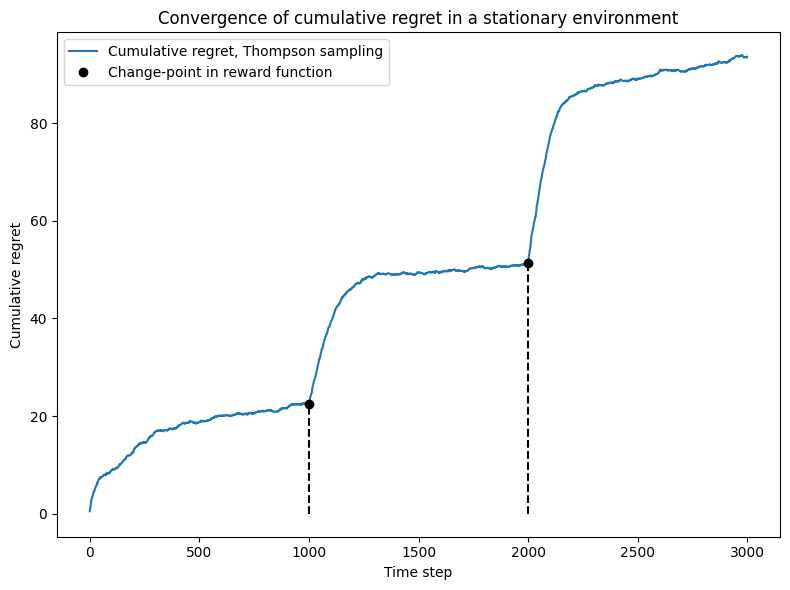

In [26]:
plt.figure()
plt.plot(cumulative_regret, label='Cumulative regret, Thompson sampling')
for index, change_point in enumerate(change_points):
    if index == 0:
        plt.plot(change_point, cumulative_regret[change_point], 'o', c='k', label='Change-point in reward function')
    else:
        plt.plot(change_point, cumulative_regret[change_point], 'o', c='k')
plt.vlines(
    x=change_points,
    ymin=[0]*len(change_points),
    ymax=[cumulative_regret[change_point] for change_point in change_points],
    colors='k',
    linestyles='dashed'
)
plt.title('Convergence of cumulative regret in a dynamic environment')
plt.xlabel('Time step')
plt.ylabel('Cumulative regret')
plt.legend()
plt.tight_layout()
plt.show()

#### 4.2 Optimal arm identification

After the GP models are trained, optimal arms can be identified for given context values. The estimated best action in *blue*, which corresponds to the arm that returns the highest expected reward, is compared to the true best action in *orange* which is found using information about the true reward function (which is unknown to the MAB agent). It can be seen that there is significant overlap of the estimated and actual best actions, which explains the sub-linear cumulative regret since the agent is making few non-optimal decisions.

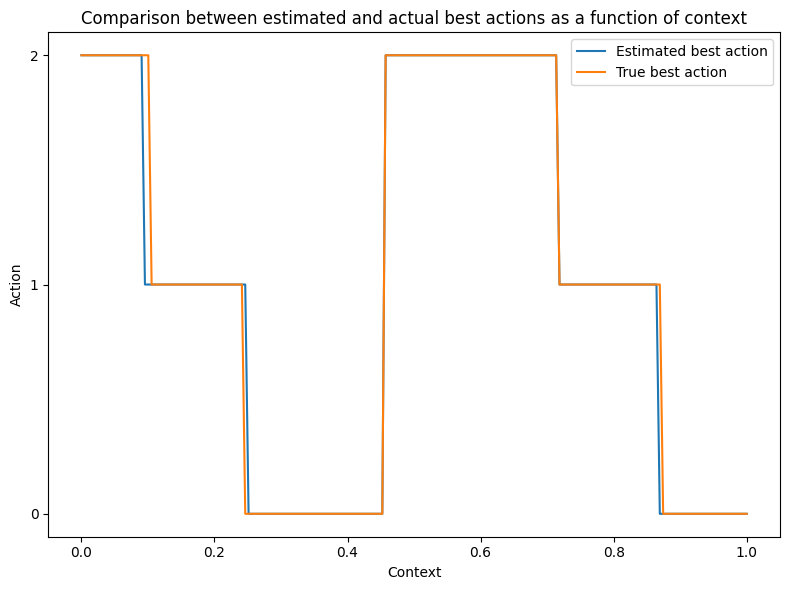

In [10]:
plt.figure()
plt.plot(domain, estimated_best_actions, label='Estimated best action')
plt.plot(domain, true_best_actions, label='True best action')
plt.title('Comparison between estimated and actual best actions as a function of context')
plt.xlabel('Context')
plt.ylabel('Action')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.tight_layout()
plt.show()

#### 4.3 Reward analysis

Finally, various reward representations of each arm are shown.
- The *dotted blue line* is the true reward function and is unknown to the MAB agent.
- The *blue dots* are the observed rewards that the MAB agent sees upon selecting an arm.
- The estimated reward function posterior is shown in *orange* including a 95% confidence interval to capture uncertainty in the GP model.

It can be seen that the TS algorithm is driving sampling decisions (arm selections) that it expects will return highest rewards. In other words, the sampling strategy is minimising regret. The variance of the observed rewards degrades regret. A purely deterministic reward with no noise would cause observed rewards to lie on the true reward function. In regions where the TS algorithm has exploited its knowledge of the posterior (high density of observed rewards), the predicted reward function mean closely approximates the true reward function.

Reward shape at plot: (100,)


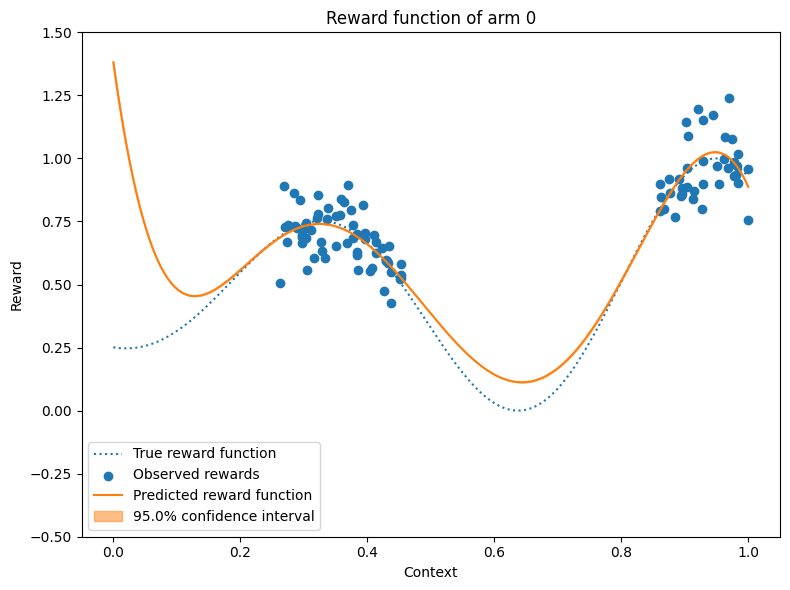

Reward shape at plot: (100,)


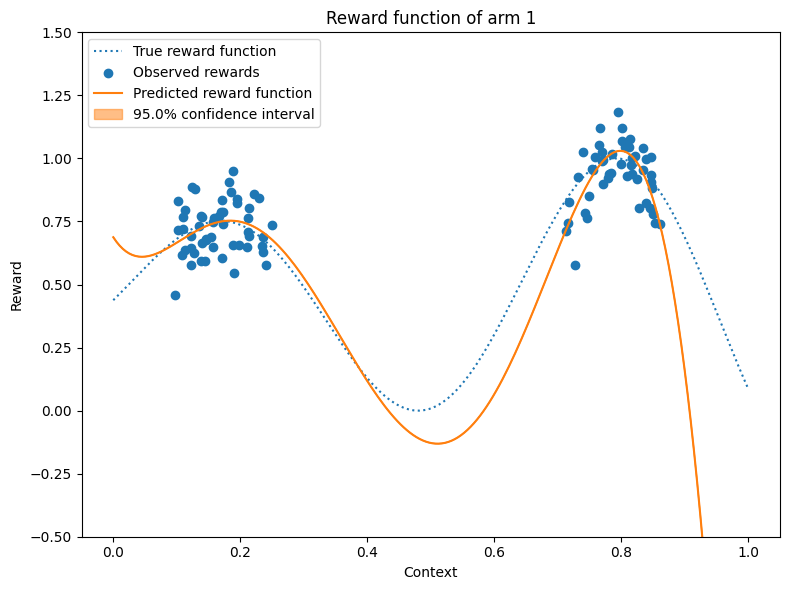

Reward shape at plot: (100,)


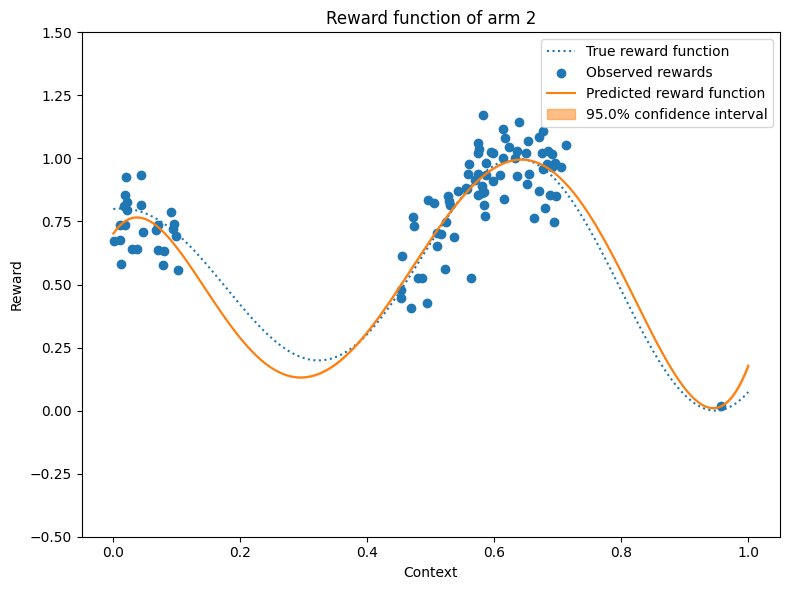

In [11]:
for arm in arms:
    arm.reward.plot()

### 5 Further work

A number of directions will be pursued in the remainder of the research project:
- **Non-stationary reward function**: this study examined the stationary contextual bandit case. The non-stationary case where the reward function can evolve over time will be explored next. This will involve setting a change-point (or set of change-points) where the reward function changes. The cumulative regret will be impacted since the learnt optimal actions will no longer be applicable under a new reward function for each arm.
- **Adaptive training schemes**: an initial, naive mitigation strategy to address non-stationarity is to apply a window to the observations that are used to train the GP. If the window remains sufficiently large for the GP to fit the true reward function, yet small enough to fit inside the space of change-points, the MAB agent can adapt to the change-points while incurring larger regret during the retraining stages. Sub-linear regret cannot be achieved globally, but can be achieved within the time steps between change-points assuming the frequency of change-points is not too large.
- **Change-point detection**: more sophisticated change-point detection algorithms can be applied to the GP models so that rather than windowing the training observations, the GP can be retrained upon a change-point detection event leading to better regret performance.

### 6 Conclusion

The study has demonstrated how a TS MAB algorithm that was adapted for stationary GP reward functions of arm and context can achieve sub-linear regret. The optimal arm to choose for all context values was estimated and compared to the true best arm based on knowledge of the true reward function for each arm. Finally, the sampling decisions were visualised to show the TS MAB agent exploits knowledge of the reward function posterior to sample arms such that regret is minimised.

### 6 References

1. Besbes O., Gur Y., Zeevi A. Optimal exploration-exploitation in a multi-armed bandit problem with non-stationary rewards. Stochastic Systems. 2019. 9(4):319-337.

2. Besbes O., Gur Y., Zeevi A. Stochastic multi-armed bandit problem with non-stationary rewards. Advances in Neural Information Processing Systems. 2014. 27.

3. Besson, L., Kaufmann, E., Maillard O., Seznec, J. Efficient change-point detection for tackling piecewise-stationary bandits. Journal of Machine Learning Research. 2022. 23(77):1−40.

4. Bogunovic I., Scarlett J., Cevher V. Time-varying Gaussian process bandit optimization. International Conference on Artificial Intelligence and Statistics. 2016. 51:314-323.

5. Bubeck S., Cesa-Bianchi N. Regret analysis of stochastic and non-stochastic multi-armed bandit problems. Foundations and Trends in Machine Learning. 2012. 5(1):1-22.

6. Chen Y., Lee C. W., Luo H., Wei C. Y. A new algorithm for non-stationary contextual bandits: Efficient, optimal and parameter-free. Conference on Learning Theory. 2019. 696-726.

7. Garivier, A., Moulines, E. On upper-confidence bound policies for non-stationary bandit problems. arXiv preprint arXiv:0805.3415. 2008.

8. Krause A., Ong C. Contextual gaussian process bandit optimization. Advances in neural information processing systems. 2011. 24.

9. Luo H., Wei C. Y., Agarwal A., Langford J. Efficient contextual bandits in non-stationary worlds. Conference On Learning Theory. 2018. 1739-1776.

10. Nyikosa, F. M., Osborne, M. A., Roberts, S. J. Bayesian optimization for dynamic problems. arXiv preprint arXiv:1803.03432. 2018.

11. Slivkins, A. Contextual bandits with similarity information. Journal of Machine Learning Research. 2014. 15:2533-2568.

12. Slivkins A., Upfal E. Adapting to a changing environment: the Brownian restless bandits. Conference on Learning Theory. 2008. 21.

13. Srinivas N., Krause A., Kakade S. M., Seeger M. Gaussian process optimization in the bandit setting: No regret and experimental design. arXiv preprint arXiv:0912.3995. 2009.

14. Wu Q., Iyer N., Wang H. Learning contextual bandits in a non-stationary environment. International ACM SIGIR Conference on Research & Development in Information Retrieval. 2018. 41:495-504.